In [1]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
env = gym.make("CartPole-v1")

In [3]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

# enable interactive mode
plt.ion();

In [4]:
# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    #"hip" if torch.backends.openmp.is_available() else 
    "cpu"
)
print(device)

mps


`Transition`: a tuple representing a single change in the environment and its corresponding action and its reward for taking such an action.

`ReplayMemory`: stores transitions and replays them. By sampling randomly, the transitions that make up a batch are decorrelated, which has been shown to improve training.

In [5]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## DQN
Let $s_t$ be the state and let $\Gamma(s_t)$ be the set of actions $a_t$ that can be taken at $s_t$ and let $t$ be time .
The purpose of this algorithm is to maximize the discounted, cumulative reward function starting from $t=t_0$:

$$R_{t_0} = \sum_{t=t_0}^\infty \gamma^{t-t_0} F(s_t, a_t)$$

where $F(s, a)$ is the reward following an action $a$ in a state $s$. The reward $R_{t_0}$ is also known as the *return*. The *discount factor* $\gamma$ should be a constant between $0$ and $1$ for the sum to converge. Notice that a smaller $\gamma$ places greater value in actions that maximize the reward in the short term over the long term.

The main idea behind Q-learning is that if we had a function $Q^*: \text{State} \times \text{Action} \to \mathbb{R}$, that could tell us what our *return* is given an action and state, then we could easily construct a policy

$$\pi^*(s) = \arg\max_{a \in \Gamma (s)} Q^*(s, a)$$

that chooses the *action* to maximize the reward function. First, $\arg\max$, not to be confused with $\max$, outputs the inputs that maximize $Q^*$. Second, $Q^*$ and $\pi^*$ denote families of functions, not any function in particular. For each $Q^\prime$, a corresponding $\pi^\prime$ is defined above.

For most experiments we are not omniscient, so we do not know $Q$. However, since *neural networks* are *universal function approximaters*, we can train a neural network to act as $Q^*$.

#### Bellman equation
In our case, $\pi^*(s)$ is a policy such that $Q^*(s, \pi(s))$ is the maxima. Hence $Q^{\pi\prime}(s) = V^\prime(s)$, defined below, is a policy that maximizes the *return* given an initial state $s$.

$$V^\prime(s_0) =  \max_{a_t \in \Gamma(s_t)} \sum_{t=t_0}^\infty \gamma^{t-t_0} F(s_t, a_t).$$


The **principle of optimality** states that an optimal policy $V$ has the property that whatever the initial state and decision are, the remaining decisions must be an optimal policy with respect to the state resulting from the first decision.

Now, let $Q^\pi(s, a)=V(s, a)$ denote the return given an initial state $s$ **and** initial action $a$. If we begin with $t_0 = 0$, a state $s_0$ and a decision $a_0$, then it must be the case that

$$V(s_0, a_0) = F(s_0, a_0) + \gamma \left[\max_{a_t \in \Gamma(s_t)} \sum_{t=1}^\infty \gamma^{t-1} F(s_t, a_t)\right]$$

and hence,

$$V^\prime(s_0) = V(s_0, \pi(s_0)) = \max_{a_0 \in \Gamma(s_0)} \left(F(s_0, a_0) + \gamma \left[\max_{a_t \in \Gamma(s_t)} \sum_{t=1}^\infty \gamma^{t-1} F(s_t, a_t)\right]\right)$$

Notice that the inside of the brackets is just $V(s_1, \pi(s_1))$. Thus

$$V(s_0, \pi(s_0)) =  \max_{a_0 \in \Gamma(s_0} \left[F(s_0, a_0) + \gamma V(s_1, \pi(s_1))\right]$$

and in general,

$$V(s, \pi(s)) =  \max_{a \in \Gamma(s)} \left[F(s, a) + \gamma V(s^\prime, \pi(s^\prime)\right]$$

where $s^\prime$ is the state that results, or follows the previous state $s$ and action $a$. 


Any reward function $Q$ with an *optimal* policy $\pi$ obeys the Bellman equation, so, 

$$Q^\pi(s, a) = F(s, a) + \gamma Q^\pi(s^\prime, \pi(s^\prime))$$

The **observed** difference between the two sides is the error:

$$\delta = Q(s, a) - (F(s, a) + \gamma\max Q(s^\prime, a^\prime))$$

which is equivalent to

$$Q(s, a) - Q^\pi(s, a)$$

where $Q(s, a)$ is the return resulting from the decisions made by the model and $Q^\pi(s, a)$ is the optimal return according to the model.


The **Huber loss** 

$$\mathcal L = \frac{1}{|B|} \sum_{(s, a, s^\prime, a^\prime)} \mathcal L(\delta)$$

where $\mathcal L(\delta) = \begin{cases} \frac{1}{2} \delta^2 & |\delta| \leq 1, \\ |\delta | - \frac{1}{2} & \text{otherwise}\end{cases}$

will be used to minimize the error. Where the *total loss* is the sum of each transitions in batch $B$. The Huber loss acts like the *mean squared error* for small values, and the *mean absolute error* when the error is large. This makes it more robust to outliers when the estimated $Q$ function is very noisy.

Notice that if $\gamma = 0$, then the error simplifies to $Q(s, a) - F(s, a)$ which in practice makes the network mimic a greedy algorithm (which is pretty pointless, as we do not need neural networks for that).

In [6]:
# For the CartPole example, n_actions=2, and n_observations=4
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

### Hyperparameters
On top of the hyperparameters in the FNN, the `select_action` function introduces a couple important ones. Predictions are made with
`select_action`, which selects an action according to an **epsilon greedy policy**. Basically, we can either use our model to choose an action, or we can choose the action *randomly* from the *action space*. The probability of choosing a random action will start at a high probability, `EPS_START`, as there is very little reason to use our policy early on. Rather, we instead encourage the model to explore. As the number of *episodes* progress our model should improve, and hence we should encourage the use of the model's learned policy by decaying the likelihood of a random decision towards `EPS_END`, where `EPS_DECAY` controls the rate of decay. `EPS_START`, `EPS_END`, `EPS_DECAY` are notable hyperparameters you may want to tune as they directly affect the noisiness of the training.

In [7]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.9
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym's action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

# env.reset() returns state as a column vector,
# however select_action takes in a row vector, shape=[1, n_observations], to feed into the NN
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # policy_net(state) is equivalent to policy_net.forward(state). 
            # policy_net outputs some value for each action. We choose the largest action to maximize the total return
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        # chooses a random action
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


### Optimization
First the batch will be sampled randomly from the set of observed *Transitions*. Hence, Transitions in a batch are generally not subsequent. 
We will then use our model to approximate $Q(s_t, a_t)$ for each $(s_t, a_t)$ in the batch.
Next, we will compute $Q^\pi(s_{t+1})$ for each state in the batch. This is then used to compute our expected values $\{Q^\pi(s, a) ~|~ s \in \text{batch}\}$ using the bellman equation

$$Q^\pi(s, a)=F(s,a) + Q^\pi(s_{t+1})$$

Then, we calculate the error-array $Q(s, a)-Q^\pi(s, a)$ and optimize it using the *Huber Loss* and *AdamW* optimization. 

One notable addition to the algorithm is the use of a slower learning `target_net`, to calculate the expected values, $Q^\pi(s_{t+1})$. Using only one network for both predicted values and the expected values creates a *feedback loop*. That is, the $Q$-values for the next state (which are used to calculate the target values) are highly *correlated* with the $Q$-values of the current state by virtue of coming from the same network. In such a model, each update changes both the predicted and evaluated in the same direction which is a *moving target problem* and causes instability in the learning process (as the target will keep changing), thus preventing the network from converging. Moreover, since the expected values are influenced by the network's errors, at each update the errors will accumulate and potentially cause the predictor $Q$ to become biased or incorrect, hindering its ability to learn the true value function. These problems can be mostly mitigated with a target network, though not completely as `target_net` is still moving towards `policy_net`. Our hope is that the network will have converged to a good state by the time `target_net` converges with it. Otherwise, we get divergent or oscillatory behavior.



In [8]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch.
    # This converts the batch-array of Transitions to a Transition of batch-arrays.
    # eg: batch.state is a tensor with shape=[BATCH_SIZE, n_observations], which we can feed into the NN.
    # eg: batch.action is a tensor with shape=[BATCH_SIZE], we can use in training
    batch = Transition(*zip(*transitions))

    # Compute a boolean mask of all non-final states in the batch (all transitions except the final one will be True)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    
    # separate out the batch elements into individual tensors.
    # Note: next_states_batch excludes the final state
    next_states_batch = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)


    # Our NN, policy_net, computes Q(s_t, a) for all a. We are interested in Q(s_t, a) for the corresponding a in action_batch. 
    # So, .gather(1, action_batch) gathers values in action_batch along dim=1.
    # It works by choosing the action_batch[i]-th column of the i-th row of policy_net(state_batch)
    # which correspond to the action value of the action which would have been taken according to the memory
    #
    # Note: action_batch.shape=[BATCH_SIZE] and policy_net(state_batch).shape=[BATCH_SIZE, num_actions]
    # moreover, 0 <= action_batch[i] < num_actions
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) = Q(s_{t+1}, pi(s_{t+1})), for use in the Bellman equation below
    # Note: target_net is a slower learning version of policy_net with an imposed learning rate TAU for the purpose of stability
    # This is because policy_net is very prone to randomness in the initalization, so 
    # we will use the slower learning target_net to compute expected values. 
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(next_states_batch).max(1).values
    # Compute the expected Q values using Bellman's equation
    # the loss function will then compare expected_state_action_values with the observed state_action_values
    expected_state_action_values = reward_batch + (next_state_values * GAMMA)

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

### Training
Training will continue until the model converges towards some learned policy. Often times a model may converge, but the stochastic nature of the *epsilon greedy policy* may make it diverge. This may actually be desirable, especially when the learned policy isn't ideal. As such, it is recommended that `EPS_END` is not $0$. 

Complete


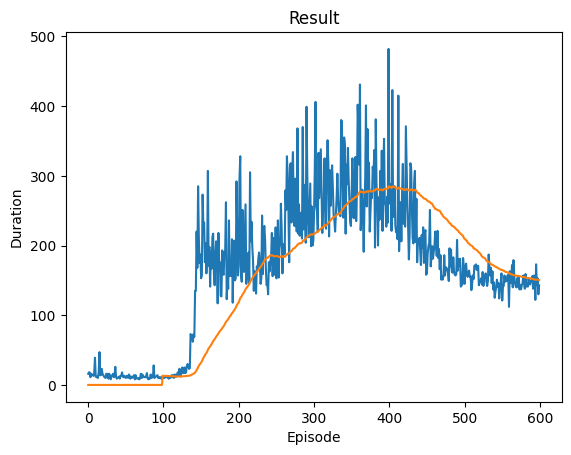

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [9]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 600
else:
    num_episodes = 600

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

### Summary
The DQN learns by examining the return values for actions chosen by a stochastic process. The model compares said actions to the optimal actions according to the network and updates the network accordingly. As the network learns, the model relys less on random choice as we would like to rely more on the policy that the model has learned. 

### Reward
The environment assigns some reward value for each decision made at some state. This reward value can be as simple as 
comparing the observations between the two states, or more complex depending on the goal you want the model to learn.





In [10]:
# 4:37 for 600 episodes
# GPU 48C to 76C